## RNN(순환 신경망, Recurrent Neural Network)

#### NP로 RNN 이해하기

In [11]:
import numpy as np

timesteps = 10 # 시점의 수. NLP에서는 보통 문장의 길이
input_dim = 4 # 입력의 차원. NLP에서는 보통 단어 벡터의 차원
hidden_size = 8 # 은닉 상태의 크기(메모리 셀의 용량)

inputs = np.random.random((timesteps, input_dim)) # 입력 2D Tensor

hidden_state_t = np.zeros((hidden_size,)) # 초기 은닉 상태

In [12]:
print(inputs.shape)
print(hidden_state_t)

(10, 4)
[0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
Wx = np.random.random((hidden_size, input_dim)) # (8,4), 입력에 대한 가중치
Wh = np.random.random((hidden_size, hidden_size)) # (8,8), 은닉 상태 가중치
b = np.random.random((hidden_size,)) # (8,), 편향(bias)

print(np.shape(Wx))
print(np.shape(Wh))
print(np.shape(b))

(8, 4)
(8, 8)
(8,)


In [16]:
for input_t in inputs:
  print(input_t.shape)
  print(input_t)
  break

(4,)
[0.4589433  0.86324712 0.77717019 0.76957596]


In [18]:
total_hidden_states = []

# (8,4)(4,) + (8,8)(8,) + (8,) = (8,)
# 셀 동작
for input_t in inputs:
  # tanh(Wx*X + Wh*H + b)
  output_t = np.tanh(np.dot(Wx, input_t) + np.dot(Wh, hidden_state_t) + b)
  total_hidden_states.append(list(output_t)) # 각 시점의 은닉상태 체크
  hidden_state_t = output_t # 은닉 상태 저장

total_hidden_states = np.stack(total_hidden_states, axis = 0) # 값 정리

print(total_hidden_states.shape)
print(total_hidden_states)

(8,)
[0.99996453 0.99997925 0.99999892 0.99999722 0.99995496 0.9999922
 0.99993341 0.99999865]
(8,)
[0.99997407 0.99997084 0.99999957 0.99999798 0.99996272 0.99999506
 0.99997275 0.99999876]
(8,)
[0.99996796 0.99995372 0.99999928 0.99999698 0.99995527 0.9999939
 0.99995922 0.99999801]
(8,)
[0.99996183 0.99998266 0.9999993  0.99999771 0.99992905 0.99999247
 0.9999443  0.99999808]
(8,)
[0.99991295 0.99985856 0.9999945  0.99998411 0.99979595 0.9999766
 0.99972246 0.99998286]
(8,)
[0.99991773 0.99988757 0.99999216 0.99998733 0.99990868 0.99998218
 0.99966446 0.99999193]
(8,)
[0.99996309 0.99993107 0.99999898 0.9999958  0.99994731 0.99999274
 0.99994696 0.99999707]
(8,)
[0.99991189 0.99997017 0.9999947  0.99999371 0.99989056 0.99998397
 0.99964804 0.99999476]
(8,)
[0.99994275 0.99997567 0.99999837 0.99999683 0.99992567 0.99999133
 0.99987851 0.999997  ]
(8,)
[0.99995622 0.99989429 0.9999977  0.99999069 0.9999202  0.99998594
 0.99990285 0.99999518]
(10, 8)
[[0.99996453 0.99997925 0.99999892 

#### 파이토치를 활용한 RNN

In [19]:
import torch
import torch.nn as nn

input_size = 5
hidden_size = 8

# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1,10,5)

cell = nn.RNN(input_size, hidden_size, batch_first=True)
# batch_first = True 는 배치 차원이 가장 앞으로 오게 함.(False 시 가장 뒤로)

In [21]:
outputs, _status = cell(inputs)
print(outputs.shape) # 모든 time_steps 의 hidden_state
print(_status.shape) # 최종 time_steps 의 hidden_state

torch.Size([1, 10, 8])
torch.Size([1, 1, 8])


In [22]:
## 은닉층 두개 RNN

# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1,10,5)

cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True)
outputs, _status = cell(inputs)
print(outputs.shape) # 모든 time_steps 의 hidden_state
print(_status.shape) # 최종 time_steps 의 hidden_state

torch.Size([1, 10, 8])
torch.Size([2, 1, 8])


In [23]:
## 양뱡향 RNN

# : 시점 t 의 출력값을 예측할 때, 이전 시점의 데이터만이 아닌 이후 데이터로도 예측할 수 있다는 아이디어에서 기반

# Forward States : 앞 시점의 은닉 상태
# Backward States : 뒤 시점의 은닉 상태

inputs = torch.Tensor(1,10,5)

# 양방향 RNN 구현 - bidirectional = True
cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True, bidirectional=True)
outputs, _status = cell(inputs)
print(outputs.shape) # 모든 time_steps 의 hidden_state - 은닉 상태가 양방향이 연결되어서 x 2됨.
print(_status.shape) # 최종 time_steps 의 hidden_state - 층 2개 * 은닉 상태 2개 -> 4

torch.Size([1, 10, 16])
torch.Size([4, 1, 8])


#### RNN 구현해보기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [3]:
# 1. RNN 을 활용해 이름 분류해보기

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2025-05-07 12:17:39--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.167.192.82, 3.167.192.5, 3.167.192.10, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.167.192.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2025-05-07 12:17:39 (32.3 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian

In [5]:
# Data setting
import string
import unicodedata

all_letters = string.ascii_letters + " .,;'" + "_"
# _ 는 문자 집합에 없는 특수 글자를 표기해서 활용하기 위해서 사용!
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

In [6]:
print(all_letters) # 아스키 레터 + 특수 문자가 들어있는 항목까지 문자로 만듬.
print(n_letters) # 전체 문자 개수
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")
 # 전체 문자에 없는 내용을 변경! 변경하는 함수

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'_
58
converting 'Ślusàrski' to Slusarski


In [7]:
# name to tensor
# one-hot vector 활용

# 문자를 all_letter 에서 찾기
def letterToIndex(letter):
  if letter not in all_letters:
    return all_letters.find("_")
  else:
    return all_letters.find(letter)

# 라인을 텐서로 바꾸기(line_length, 1, n_letters)
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor


In [8]:
print(letterToIndex('J'))
print(lineToTensor('Ahnt').shape)
print(lineToTensor('Ahnt'))

35
torch.Size([4, 1, 58])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [9]:
# Dataset 만들기

from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):
  def __init__(self, data_dir):
    self.data_dir = data_dir # 데이터 세트 주소
    self.load_time = time.localtime # 데이터셋 로드를 위해
    labels_set = set() # 모든 클래스를 위한 set 집합

    self.data = []
    self.data_tensors = []
    self.labels = []
    self.labels_tensors = []

    # 폴더에 있는 txt 파일 전부 읽기
    text_files = glob.glob(os.path.join(data_dir, '*.txt'))
    for filename in text_files:
      label = os.path.splitext(os.path.basename(filename))[0]
      labels_set.add(label)
      lines = open(filename, encoding='utf-8').read().strip().split('\n')
      for name in lines:
        self.data.append(name)
        self.data_tensors.append(lineToTensor(name))
        self.labels.append(label)

    # 레이블의 텐서 표시 캐치
    self.labels_uniq = list(labels_set)
    for idx in range(len(self.labels)):
      temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
      self.labels_tensors.append(temp_tensor)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data_item = self.data[idx]
    data_label = self.labels[idx]
    data_tensor = self.data_tensors[idx]
    label_tensor = self.labels_tensors[idx]

    return label_tensor, data_tensor, data_label, data_item

In [10]:
alldata = NamesDataset('data/names')
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[4000]}")

loaded 20074 items of data
example = (tensor([16], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.

In [11]:
text_files_test = glob.glob(os.path.join('data/names', '*.txt'))
print(len(text_files_test), text_files_test)
text_files_test[1]
label_test = os.path.splitext(os.path.basename(text_files_test[1]))[0]
print(label_test)
lines_test = open(text_files_test[1], encoding='utf-8').read().strip().split('\n')
print(lines_test)
print(lines_test[0])
print(lineToTensor(lines_test[0]))

18 ['data/names/French.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt']
Polish
['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz', 'Bernard', 'Bobienski', 'Bosko', 'Broż', 'Brzezicki', 'Budny', 'Bukoski', 'Bukowski', 'Chlebek', 'Chmiel', 'Czajka', 'Czajkowski', 'Dubanowski', 'Dubicki', 'Dunajski', 'Dziedzic', 'Fabian', 'Filipek', 'Filipowski', 'Gajos', 'Gniewek', 'Gomolka', 'Gomulka', 'Gorecki', 'Górka', 'Górski', 'Grzeskiewicz', 'Gwozdek', 'Jagoda', 'Janda', 'Janowski', 'Jaskolski', 'Jaskulski', 'Jedynak', 'Jelen', 'Jez', 'Jordan', 'Kaczka', 'Kaluza', 'Kamiński', 'Kasprzak', 'Kava', 'Ke

In [14]:
import torch

# 데이터 분할
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15],
generator = torch.Generator(device=device).manual_seed(2024))

print(f"train example = {len(train_set)}, validation example = {len(test_set)}")

train example = 17063, validation example = 3011


In [15]:
alldata[1][1].shape

torch.Size([7, 1, 58])

In [16]:
# RNN 구현

import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__() # 현 클래스의 부모클래스(상위 클래스) 에 접근하는데 사용(nn.Module의 생성자 호출)

    self.rnn = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size) # 출력층
    self.softmax = nn.LogSoftmax(dim=1) # 분류를 위한 층

  def forward(self, line_tensor):
    rnn_out, hidden = self.rnn(line_tensor)
    output = self.h2o(hidden[0]) # 시퀀스 전체를 요약한 정보 가지고 오기
    output = self.softmax(output)

    return output

In [17]:
n_hidden = 128

rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [18]:
# 텐서를 RNN 에 전달하여 예측된 출력 -> 텍스트 레이블 도출하기
def label_from_output(output, output_labels):
  top_n, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9083, -2.8609, -2.8313, -2.8442, -2.9897, -2.7527, -2.9878, -2.8650,
         -2.8306, -2.8358, -2.8822, -2.9612, -2.8571, -3.0163, -2.9097, -2.9252,
         -2.9189, -2.8883]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Dutch', 5)


In [ ]:
# 훈련하기

import random
import numpy as np

# 데이터 셋 형식
# (label_tensor, text_tensor, label, text)
# (레이블 텐서, 텍스트 텐서, 라벨 원래값(디버깅용), 텍스트 원래값(디버깅용))
def train(rnn, training_data, n_epoch = 10, n_batch_size=64, report_every = 50, learning_rate=0.2, criterion = nn.NLLLoss()):
  '''
  Learn on a batch of training_data for a specified number of iterations and reporting thresholds
  '''
  # 플로팅을 위한 손실 추적
  current_loss = 0 # epoch의 누적 손실 저장
  all_losses = [] # 각 epoch 의 평균 손실 저장
  rnn.train()
  optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate) # 확률적 경사 하강법으로 옵티마이저 정의

  start = time.time()
  print(f'training on data set with n = {len(training_data)}')

  for iter in range(1, n_epoch+1):
    rnn.zero_grad() # 기울기 초기화

    # 미니 배치 만들기
    batches = list(range(len(training_data)))
    random.shuffle(batches)
    batches = np.array_split(batches, len(batches) // n_batch_size) # 데이터를 n_batch_size 로 분할

    for idx, batch in enumerate(batches):
      batch_loss = 0 # 해당 배치의 총 손실 저장
      for i in batch: # 배치 내 각 데이터 포인트 처리
        (label_tensor, text_tensor, label, text) = training_data[i]
        output = rnn.forward(text_tensor)
        loss = criterion(output, label_tensor)
        batch_loss += loss

      # optimize parameters
      batch_loss.backward() # 손실에 대한 기울기 계산
      nn.utils.clip_grad_norm_(rnn.parameters(), 3) # 기울기 폭발 방지 클리핑
      optimizer.step() # 가중치 업데이트
      optimizer.zero_grad() # 배치 가중치 초기화

      current_loss += batch_loss.item() / len(batch) # 현재 batch의 평균 손실 계산

    all_losses.append(current_loss / len(batches) ) # 현재 epoch 의 평균 손실 저장
    if iter % report_every == 0:
      print(f'{iter} ({iter / n_epoch:.0%}) : \t average batch loss = {all_losses[-1]}')
    current_loss = 0

  return all_losses


In [20]:
# 미니 배치를 사용해서 지정된 에포크만큼 학습 시키기

start = time.time()
all_losses = train(rnn, train_set, n_epoch = 27, learning_rate=0.15, report_every= 5)
end = time.time()
print(f'training time = {end - start}')

training on data set with n = 17063
5 (19%) : 	 average batch loss = 0.8806297821537341
10 (37%) : 	 average batch loss = 0.6917866680613827
15 (56%) : 	 average batch loss = 0.5808458103479989
20 (74%) : 	 average batch loss = 0.4950666435472258
25 (93%) : 	 average batch loss = 0.4383547884913591
training time = 499.17403960227966


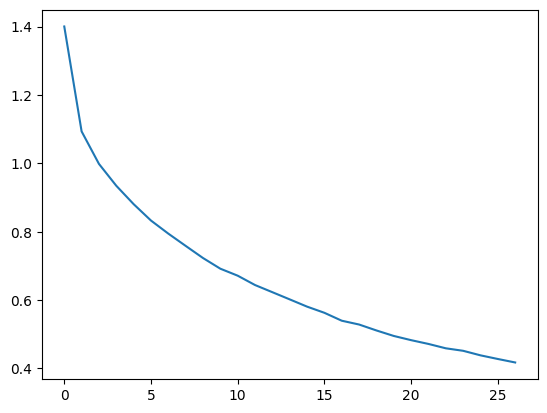

In [21]:
# 결과 플로팅

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

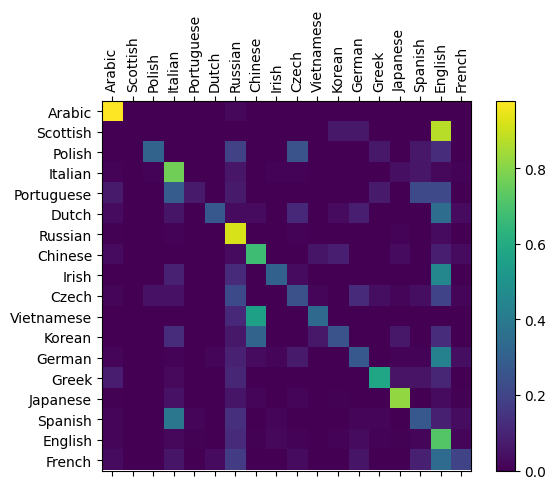

In [23]:
# 결과 평가
def evaluate(rnn, testing_data, classes):
  confusion = torch.zeros(len(classes), len(classes))

  rnn.eval() # 평가모드 설정
  with torch.no_grad():
    for i in range(len(testing_data)):
      (label_tensor, text_tensor, label, text) = testing_data[i]
      output = rnn(text_tensor)
      guess, guess_i = label_from_output(output, classes)
      label_i = classes.index(label)
      confusion[label_i][guess_i] += 1

  # 모든 행을 합계로 나누어 정규화
  for i in range(len(classes)):
    denom = confusion[i].sum()
    if denom > 0:
      confusion[i] = confusion[i] / denom

  # plot 세팅
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.cpu().numpy())
  fig.colorbar(cax)

  # 축 설정
  ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
  ax.set_yticks(np.arange(len(classes)), labels=classes)

  # 모든 tick에서 레이블 출력
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

evaluate(rnn, test_set, classes=alldata.labels_uniq)

In [ ]:
# RNN 층을 사용하지 않고 직접 구현하기
# https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

# 문자수준 RNN 을 통한 이름 생성

In [2]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 #EOS 마커 추가

def findFiles(path): return glob.glob(path)

# 아스키코드로 변경
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

# 파일 읽기
def readLines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]

# 카테고리 라인별 사전 구축
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found. Make sure that you downloadea data '
  'from https://download.pytorch.org/tutorial/data.zip and extract it to '
  'the current directory')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Portuguese', 'Vietnamese', 'Italian', 'Russian', 'Dutch', 'Arabic', 'Korean', 'Scottish', 'French', 'Czech', 'Spanish', 'English', 'German', 'Japanese', 'Chinese', 'Irish', 'Polish', 'Greek']
O'Neal


In [3]:
# network 만들기
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)



In [11]:

rnn = RNN(input_size=n_letters, hidden_size=128, output_size=n_letters)
print(rnn)

RNN(
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [4]:
# 훈련 준비(무작위 쌍 만들기)
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

# 랜덤 카테고리 및 라인 추첨
def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

각 타임스텝(학습단어의 각 글자) 에 대해
네트워크 입력 - (category, current letter, hidden state)
네트워크 출력 - (next letter, next hidden state)

각 학습 세트 - category(카테고리), a set of input letters(입력 글자 세트), a set of output/target letter(출력 글자 세트) 필요

In [5]:
# one-hot vector 텐서의 카테고리
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

# input 의 첫번째부터 마지막 글자의 one-hot 행렬(EOS 미포함)
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

# 두번쨰 문자부터 끝까지의 텐서
def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters -1) # EOS
  return torch.LongTensor(letter_indexes)


# 훈련 중 편의를 위한 임의 쌍에 대한 변환
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
# Train

criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()

  rnn.zero_grad()

  loss = torch.Tensor([0]) # 쉽게 loss = 0 으로 이용 가능

  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l

  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item() / input_line_tensor.size(0)

In [7]:
# 훈련의 걸리는 시간 추척
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m * 60
  return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if iter % print_every == 0:
    print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0

0m 16s (5000 5%) 2.9702
0m 33s (10000 10%) 2.3792
0m 50s (15000 15%) 2.8963
1m 7s (20000 20%) 1.7105
1m 23s (25000 25%) 2.4968
1m 39s (30000 30%) 3.0477
1m 56s (35000 35%) 2.8261
2m 12s (40000 40%) 1.8244
2m 29s (45000 45%) 2.1647
2m 46s (50000 50%) 2.2372
3m 1s (55000 55%) 2.8247
3m 18s (60000 60%) 2.4112
3m 34s (65000 65%) 2.7064
3m 50s (70000 70%) 2.1633
4m 6s (75000 75%) 1.4919
4m 22s (80000 80%) 3.0297
4m 38s (85000 85%) 2.6007
4m 55s (90000 90%) 1.2428
5m 11s (95000 95%) 3.0324
5m 27s (100000 100%) 1.9461


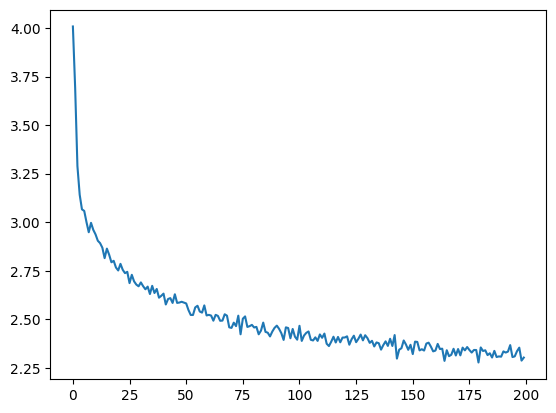

In [9]:
# 손실 확인
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

In [10]:
# 샘플 출력
max_length = 20

# 샘플 카테고리 및 처음 문자 제공
def sample(category, start_letter='A'):
  with torch.no_grad(): # 샘플 내용 추적 X
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

    return output_name

# 여러개의 시작 문자에 대한 샘플 구현
def samples(category, start_letters = 'ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Korean', 'KOR')

samples('Chinese', 'CHI')


Roverik
Uakilov
Sakilakiv
Garer
Eres
Roure
Sallo
Para
Allou
Ko
Oho
Ro
Chi
Han
Iua
